In [44]:
import sys
import os
import time
import pandas as pd
import pathlib
tutorial_path = pathlib.Path().resolve()
# Importing the main code.
module_path = os.path.abspath(os.path.join('..', 'src', 'ocloc'))
if module_path not in sys.path:
    sys.path.append(module_path)

from ocloc import ProcessingParameters, ClockDrift
from ocloc import read_correlation_file

# OCloC Python Package - Inverse strategies

## Step 1: Loading the interferometric responses

Given that Github has a limited capacity to upload data, please request the dataset to David Naranjo (d.f.naranjohernandez@tudelft.nl).
Then, change the path2datadir variable to the location of this folder in your computer.

In [2]:
# Parameters for locating the files where the correlation files and station 
# information is contained.
path2data_dir = "/Users/localadmin/Dropbox/GitHub/data"
# The reference time is zero time to which the dates of the correlations
# will be compared. It can be the date of deployment. 
reference_time = '2014-08-21T00:00:00.000000Z'

station_file = os.path.join(tutorial_path, "station_info")

Then we indicate the station_file which contains the metadata of our stations. By using Pandas we can check the first 5 rows of this file. This is a csv file with a header.

When adapting the station_file to your own needs, it is very important to modify the column (needs_correction) as this will determine which stations are going to be checked and corrected for timing errors. In this example we set this value as True for all the OBSs, but you can also set it to True for land stations.

Then we proceed to load this information to the ClockDrift object. The ClockDrift object stores all the information of the different cross-correlations, station metadata and parameters used for processing the data. 
If there are no cross-correlations available for a given station, the program will let you know.

In [59]:
params2 = ProcessingParameters(
                 freqmin = 0.2, # Low freq. for the bandpass filter
                 freqmax = 0.4, # High freq. for the bandpass filter 
                 ref_vel = 4500, # m/s
                 dist_trh = 2.5, # Minimum station separation in terms of wavelength
                 snr_trh = 30, # Signal-to-noise ratio threshold
                 noise_st = 240, # start of the noise window.
                 dt_err = 0.004, # Sampling interval needs to be multiple of this value.
                 resp_details = False)

cd = ClockDrift(station_file, path2data_dir, 
                  reference_time = '2014-08-21T00:00:00.000000Z',
                  list_of_processing_parameters=[params2])#, params3])
cd.calculate_aprioridt_4_allcorrelations_corrected()
cd.calculate_dt_ins()
cd.calculate_tapp_4_allcorrelations()

No correlation file found for station:O26
Calculating the apriori estimates for each stationpair
Calculating the t_app for each stationpair.


In [ ]:
cd2 = ClockDrift(station_file, path2data_dir, 
                  reference_time = '2014-08-21T00:00:00.000000Z',
                  list_of_processing_parameters=[params2])#, params3])

In [56]:
import ocloc
import importlib
importlib.reload(ocloc)
from ocloc import ClockDrift
cd.iteration = 1

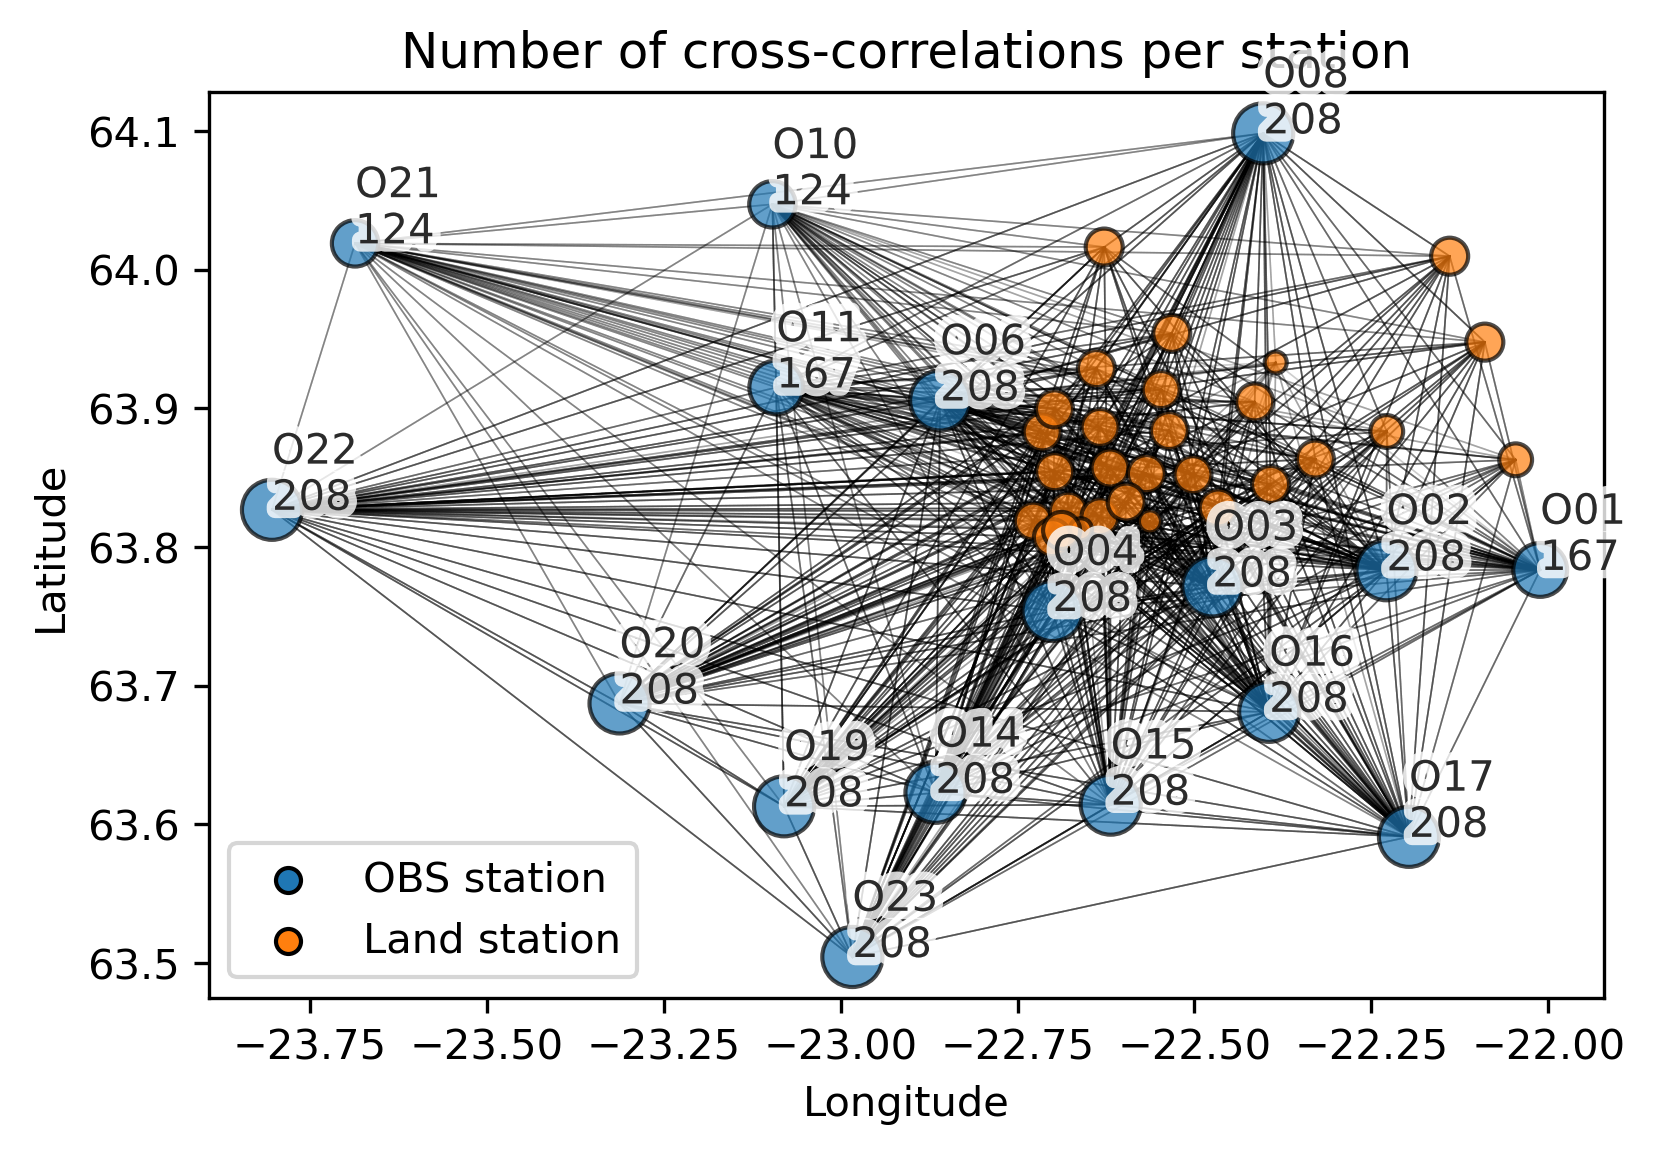

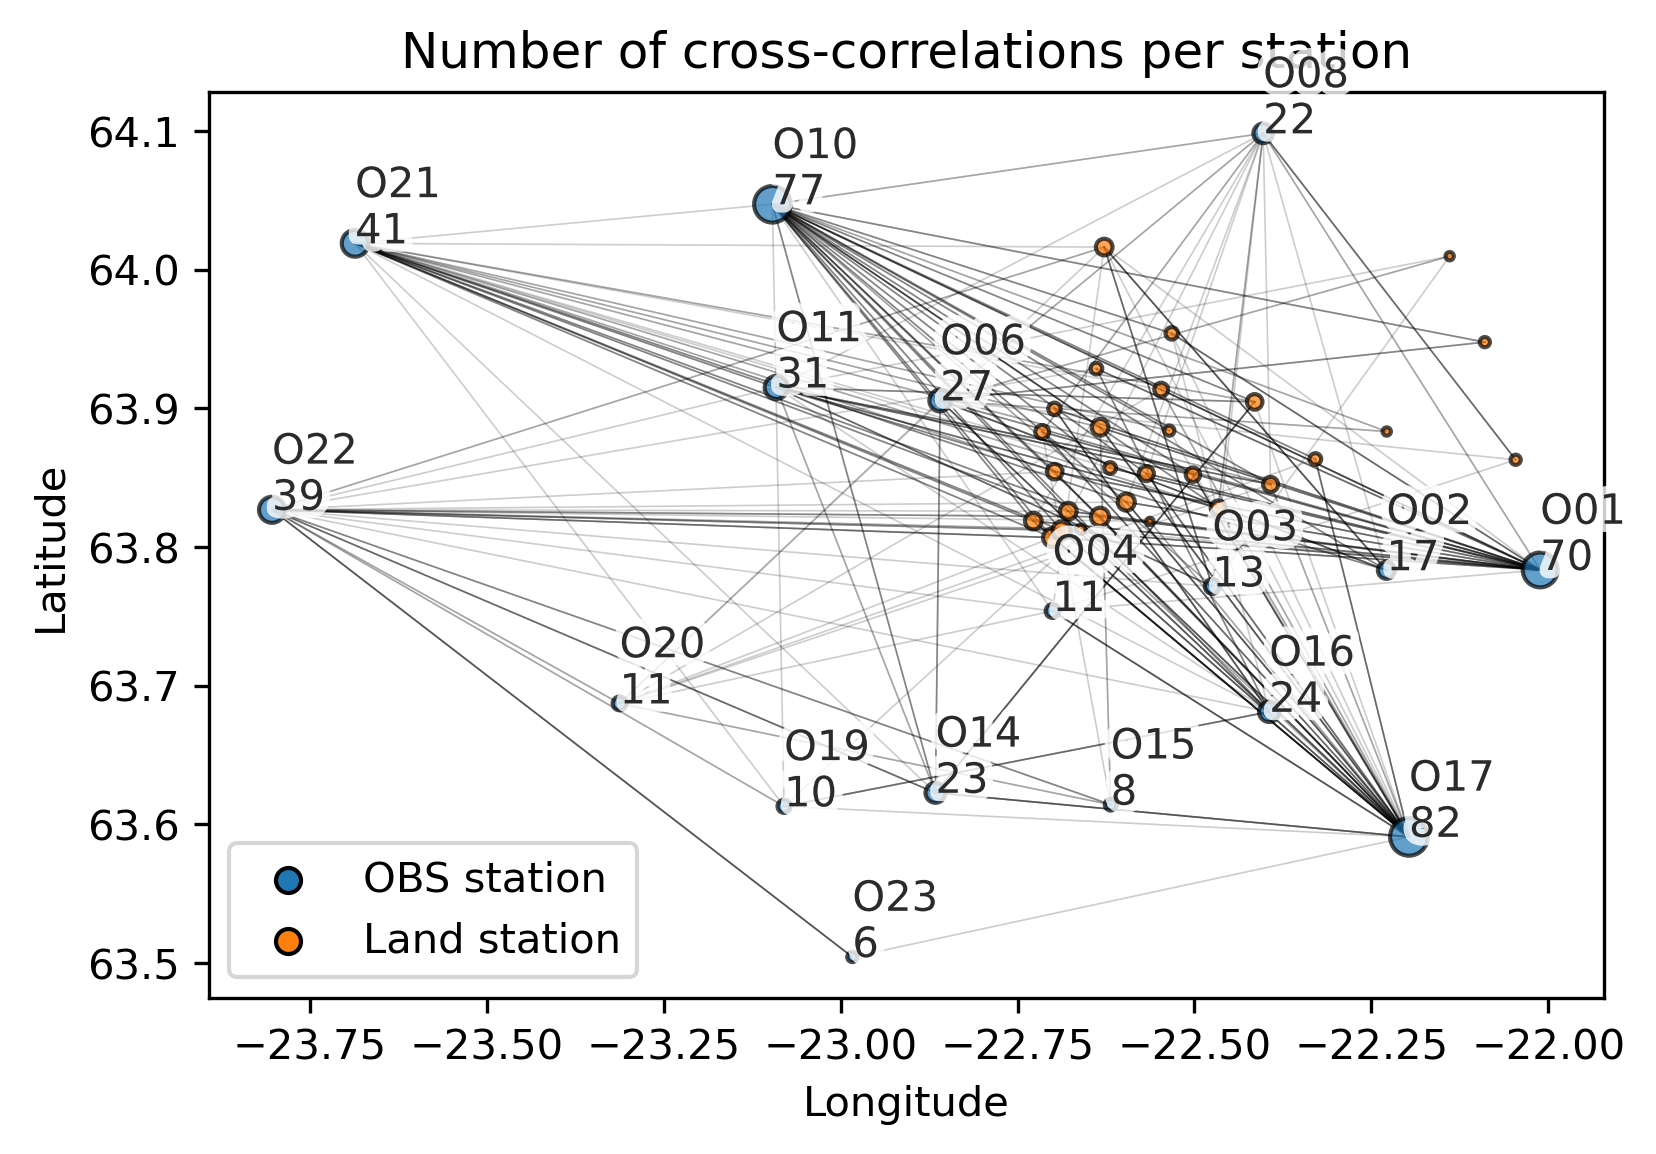

In [51]:
cd2.plot_inventory_correlations()
cd.plot_inventory_correlations()

In [66]:
type(self.correlations[0].average_date)

obspy.core.utcdatetime.UTCDateTime

# Stations with not enough time span

In [98]:
self = cd.copy()
import numpy as np

days_apart = 120
# Code for removing stations with correlations that are concnetrated in
# a period of time.
for station in self.stations:
    correlations = self.get_correlations_of_station(station.code)
    t_apps = [c.t_app[-1] for c in correlations]
    if all(flag is np.nan for flag in t_apps):
        continue
    
    dates = [] # List of dates with t_app.
    for c in correlations:
        if c.t_app[-1] is not np.nan:
            dates.append(c.average_date)

    time_difference = max(dates) - min(dates)
    if time_difference / 86400 < days_apart:
        print(station.code)

O10
O15
O21
BER
KUG
LFE
KRV


# Removing stations with only one correlation.

In [107]:
self = cd.copy()
import numpy as np

days_apart = 100
# Code for removing stations with correlations that are concnetrated in
# a period of time.
for i, station1 in enumerate(self.stations):
    for station2 in self.stations[i+1:]:
        correlations = self.get_correlations_of_stationpair(
            station1.code,
            station2.code
            )
        t_apps = [c.t_app[-1] for c in correlations]
        if all(flag is np.nan for flag in t_apps):
            continue
        
        dates = [] # List of dates with t_app.
        for c in correlations:
            if c.t_app[-1] is not np.nan:
                dates.append(c.average_date)

        if len(dates) == 1:
            print(station1.code, station2.code)
            
        #time_difference = max(dates) - min(dates)
        #if time_difference / 86400 < days_apart:
        #    print(station1.code, station2.code)

O01 O04
O01 KEF
O01 KRV
O02 O08
O03 O08
O03 O22
O03 KUG
O04 O10
O04 O20
O04 O22
O04 KEF
O04 ARN
O06 O20
O06 ARN
O08 O11
O08 ONG
O08 RAH
O08 HOP
O08 KHR
O08 SKF
O10 O19
O10 O21
O11 O16
O11 O22
O11 KUG
O14 O21
O15 HAS
O16 O21
O16 O22
O16 PAT
O17 O19
O17 O23
O17 KEF
O17 LFE
O17 PAT
O17 SKH
O19 O21
O19 SDV
O20 KEF
O20 RET
O20 SKG
O20 HOP
O20 STF
O21 EIN
O21 KEF
O21 RAH
O21 STF
O22 BER
O22 HAH
O22 RAR
O22 STA
O22 KHR


cd2 = cd.copy()
cd2.calculate_aprioridt_4_allcorrelations_corrected()
cd2.calculate_dt_ins()
cd2.calculate_tapp_4_allcorrelations()
cd2.build_matrices()
cd2.solve_eq(method="weighted_lstsq")
cd2.remove_outiers(max_error=1.)
cd2.calculate_dt_ins()
cd2.build_matrices()
cd2.solve_eq(method="weighted_lstsq")


In [ ]:
    def remove_outiers(self, max_error=2, iteration=-1):
        for sta1 in self.stations:
            average_residuals = []
            for sta2 in self.stations:
                if sta1 == sta2:
                    average_residuals.append(np.nan)
                    continue
                station1_code, station2_code = sta1.code, sta2.code
                correlations = self.get_correlations_of_stationpair(
                    station1_code, station2_code
                )
                if len(correlations) == 0:
                    average_residuals.append(np.nan)
                    continue
                station1 = self.get_station(correlations[0].station1_code)
                station2 = self.get_station(correlations[0].station2_code)

                if not station1.included_in_inversion:
                    continue
                if not station2.included_in_inversion:
                    continue
                a_val_sta1, a_val_sta2 = 0, 0
                b_val_sta1, b_val_sta2 = 0, 0
                if station1.needs_correction:
                    a_val_sta1 = float(station1.a[iteration])
                    b_val_sta1 = float(station1.b[iteration])

                if station2.needs_correction:
                    a_val_sta2 = float(station2.a[iteration])
                    b_val_sta2 = float(station2.b[iteration])

                for correlation in correlations:
                    t_N_lps = correlation.t_N_lps
                    dt_ins_i = a_val_sta1 * t_N_lps + b_val_sta1
                    dt_ins_j = a_val_sta2 * t_N_lps + b_val_sta2
                    predicted = 2 * (dt_ins_i - dt_ins_j)
                    observed = float(correlation.t_app[iteration])
                    residual = observed - predicted
                    if abs(residual) > abs(max_error):
                        correlation.t_app[iteration] = np.nan

In [ ]:
cd.calculate_aprioridt_4_allcorrelations_corrected()
cd.calculate_dt_ins()
cd.calculate_tapp_4_allcorrelations()
cd.build_matrices()
cd.solve_eq(method="weighted_lstsq")
#cd.plot_observed_vs_predicted()

In [105]:
cd.calculate_aprioridt_4_allcorrelations_corrected()
cd.calculate_dt_ins()
cd.calculate_tapp_4_allcorrelations()
cd.build_matrices()
cd.solve_eq(method="weighted_lstsq")
# cd.remove_outiers(max_error=1.)
cd.calculate_dt_ins()
cd.build_matrices()
cd.solve_eq(method="weighted_lstsq")

Calculating the apriori estimates for each stationpair
Calculating the t_app for each stationpair.
Calculating a and b for each station.
The weighting is done based on the station separation.
Calculating a and b for each station.
The weighting is done based on the station separation.


In [ ]:
cd.plot_inventory_correlations()
cd.plot_observed_vs_predicted()


# Checking that the corrections we are applying are not introducing errors into our data.

For checking our intermidiate results is critical to check that the waveforms of different time-lapses align in a better way than before starting our operation.

In [ ]:
cd.plot_correlation_beforeNafter_correction("O08", "GEV")

In [ ]:
station1_code, station2_code = "O01", "KEF"
for sta in cd.stations[:]:
    if sta.needs_correction:
        cd.plot_correlation_beforeNafter_correction(sta.code, station2_code)

# Convergence
We can run several inversions until the a and b values stop changing.
This can be checked by plotting the a's and b's of each station and looking for results that do not change anymore.


In [51]:
for i in range(3):
    cd.calculate_tapp_4_allcorrelations()
    cd.calculate_dt_ins()
    cd.remove_outiers(max_error=1.)
    cd.calculate_dt_ins()
    cd.build_matrices()
    cd.solve_eq(method="weighted_lstsq")

Calculating the t_app for each stationpair.
Calculating a and b for each station.
The weighting is done based on the station separation.
Calculating the t_app for each stationpair.
Calculating a and b for each station.
The weighting is done based on the station separation.
Calculating the t_app for each stationpair.
Calculating a and b for each station.
The weighting is done based on the station separation.


In [ ]:
cd.plot_fluctuation_of_a_and_b()
cd.plot_inv_correlations()
cd.plot_hist_no_correlations_per_station("O20")

It is also important to check that our predicted values and observed values do not differ too much. This can be done using the following function.

Note: If the values do not fit in the line 1:1, there might be some errors.

In [ ]:
cd.plot_observed_vs_predicted()

We therefore verify again that the waveform alignments improved.

In [16]:
# station2_code = "KEF"
# for sta in cd.stations[:]:
#     if sta.needs_correction:
#         cd.plot_correlation_beforeNafter_correction(sta.code, station2_code)

# Inversion strategies tested with bootstrapping

We now compare the results from a weighted least squares inversion with the regular least squares inverison.

Bootstrapping is a kind of resampling. The idea is that we treat the sample as if it were the entire population, and simulate the sampling process by choosing random rows with replacement. DataFrame provides a method called sample we can use to select a random sample of the rows (Downey, 2020).

From the x measurements we select a subset of x measurements and we invert.
We store the mean a value and mean b value.
Then we repeat.

In [111]:
from obspy.geodetics.base import gps2dist_azimuth
import numpy as np

self = cd.copy()
method = 'lstsq'
rcond = None
def bootstrap(self, method='weighted'):
    """
    
    """
    # The following two lists will store all the a and b values.
    # After finishing with all the stations we will compute the mean of these
    # values and save it into self.mean_bootstrap_a and self.mean_bootstrap_b
    bootstrap_a_values = []
    bootstrap_b_values = []
    # Firstly, we get a copy of the matrix A that we want to invert.
    A_dum = self.matrix_A.copy()
    n_measurements = cd.matrix_A.shape[0] # Number of measurements

    # Now we make the index vector of matrix A so that it coincides
    # with the index of the vector t_app (which contains our actual measurements)
    A_dum = A_dum.set_index([pd.Index(range(n_measurements))])

    # Now we bootstrap our matrix. By adding the replace=True, we make sure
    # that the sampling can repeat rows (which is necesary for applying the bootstrap).
    bootstrap_matrix_A = A_dum.sample(n=n_measurements, replace=True)

    # Because the measured data is stored within self.df, we need to
    # make a copy of df by choosing only the rows from our bootstrapped
    # matrix A.
    # Remember that df contains the time shifts (or our measurements)
    # plus a bunch of other information. Right now we want only the
    # measurements.
    df_dum = self.df.loc[bootstrap_matrix_A.index.to_list()]

    # Now we select only the data vector that will be used for the inversion.
    # Remember the data vector is the measured time shifts.
    bootstrap_T_obs = df_dum['t_app[s]'].copy()

    # Now we save the results and run the inversion.
    self.bootstrap_matrix_A = bootstrap_matrix_A
    self.bootstrap_T_obs = bootstrap_T_obs

    # The inversion starts here.
    if method == "lstsq":
        print("Inverting the matrix and calculating a and b for each station.")
        x, _, rank, _, = np.linalg.lstsq(bootstrap_matrix_A, bootstrap_T_obs, rcond=rcond)

    elif method == "weighted_lstsq":
        print("Inverting the matrix and calculating a and b for each station.")
        print("The weighting is done based on the station separation.")
        
        # Now we define the data weighting vector W
        W = []

        for i in range(len(self.matrix_A.index)):
            station1_code, station2_code = (
                self.matrix_A.index[i].split("_"))
            station1 = self.get_station(station1_code)
            station2 = self.get_station(station2_code)
            # Station separation.
            # Great circle distance in m using WGS84 ellipsoid.
            cpl_dist = gps2dist_azimuth(station1.latitude,
                                        station1.longitude,
                                        station2.latitude,
                                        station2.longitude)[0]
            W.append(cpl_dist)
        W = np.array(W)
        
        W = np.sqrt(np.diag(W))
        Aw = np.dot(W, bootstrap_matrix_A)
        Bw = np.dot(bootstrap_T_obs, W)
        x, _, rank, _,  = np.linalg.lstsq(Aw, Bw, rcond=rcond)
    else:
        msg = "You have to choose an inversion method that can be 'lstsq' for"
        msg += "least squares inversion or 'weighted_lstsq' for weighted least"
        msg += "squares inversion."
        raise Exception(msg)

    if rank < bootstrap_matrix_A.shape[1]:
        return
    ######## Now with the inversion results we have to accomodate them to a matrix.######ß
    # 
    column_names = [i.replace("*t_{N_lps}", "") for i in bootstrap_matrix_A.columns]
    sol = pd.DataFrame(columns=column_names)
    sol.loc["values"] = x

    # This list will be used to verify that all stations have solutions.
    stations_with_solutions = []
    for value, header in zip(x, column_names):
        if "a" in header:
            station_code = header.replace("a (", "").replace(")", "")
            stations_with_solutions.append(station_code)
            station = self.get_station(station_code)
            # station.bootstrap_a.append(value)
            bootstrap_a_values.append(value)
            continue
        if "b" in header:
            station_code = header.replace("b (", "").replace(")", "")
            station = self.get_station(station_code)
            # station.bootstrap_b.append(value)
            bootstrap_b_values.append(value)
    # Make the correction be equal to zero for stations without
    # measurements.
    for station in self.stations:
        if station.needs_correction:
            if station.code not in stations_with_solutions:
                station.bootstrap_a.append(0)
                station.bootstrap_b.append(0)
                self.bootstrap_a.append(0)
                self.bootstrap_b.append(0)
                print(station)
    self.mean_bootstrap_a.append(np.mean(bootstrap_a_values))
    self.mean_bootstrap_b.append(np.mean(bootstrap_b_values))
    print(rank)
    if abs(np.mean(bootstrap_b_values)) > 1:
        sol.to_csv("/Users/localadmin/Downloads/check.csv")
        bootstrap_matrix_A.to_csv("/Users/localadmin/Downloads/matrix_a.csv")
        df_dum.to_csv("/Users/localadmin/Downloads/df.csv")
        

In [112]:
test_method = 'normal'

import matplotlib.pyplot as plt
import seaborn as sns
no_iterations = 10000

def bootstrap_results(self, method='weighted', no_iterations=100, showfliers=True):
    self.bootstrap_iteration = 0
    self.mean_bootstrap_a = []
    self.mean_bootstrap_b = []

    for i in range(no_iterations):
        #with suppress_stdout():
        bootstrap(self, method=method)

    fig, axs = plt.subplots(1,2, figsize=(10, 5), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .4)
    axs = axs.ravel()

    x = self.mean_bootstrap_a 
    sns.distplot(x, bins=10, kde=False, color='C0', ax=axs[0])
    ax2 = axs[0].twinx()
    sns.boxplot(x=x, ax=ax2, color='C0', showfliers=showfliers)
    ax2.set(ylim=(-.5, 10))
    axs[0].set_ylabel('Number of events')
    axs[0].set_xlabel('Mean a values')
    plt.title(method)

    x = self.mean_bootstrap_b 
    sns.distplot(x, bins=10, kde=False, color='C0', ax=axs[1])
    ax2 = axs[1].twinx()
    sns.boxplot(x=x, ax=ax2, color='C0', showfliers=showfliers)
    ax2.set(ylim=(-.5, 10))
    axs[1].set_ylabel('Number of events')
    axs[1].set_xlabel('Mean b values')
    plt.title(method)
    plt.show()

Inverting the matrix and calculating a and b for each station.
The weighting is done based on the station separation.
34
Inverting the matrix and calculating a and b for each station.
The weighting is done based on the station separation.
34
Inverting the matrix and calculating a and b for each station.
The weighting is done based on the station separation.
34
Inverting the matrix and calculating a and b for each station.
The weighting is done based on the station separation.
34
Inverting the matrix and calculating a and b for each station.
The weighting is done based on the station separation.
34
Inverting the matrix and calculating a and b for each station.
The weighting is done based on the station separation.
34
Inverting the matrix and calculating a and b for each station.
The weighting is done based on the station separation.
34
Inverting the matrix and calculating a and b for each station.
The weighting is done based on the station separation.
34
Inverting the matrix and calcula

/Users/localadmin/opt/anaconda3/envs/obsrocko/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/localadmin/opt/anaconda3/envs/obsrocko/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


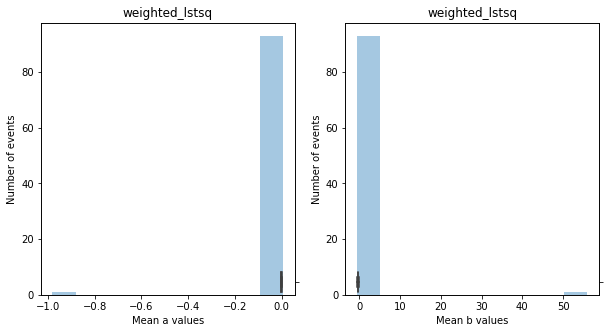

In [113]:
bootstrap_results(cd, method="weighted_lstsq", no_iterations=100, showfliers = False)

Inverting the matrix and calculating a and b for each station.
34
Inverting the matrix and calculating a and b for each station.
34
Inverting the matrix and calculating a and b for each station.
34
Inverting the matrix and calculating a and b for each station.
34
Inverting the matrix and calculating a and b for each station.
34
Inverting the matrix and calculating a and b for each station.
34
Inverting the matrix and calculating a and b for each station.
34
Inverting the matrix and calculating a and b for each station.
34
Inverting the matrix and calculating a and b for each station.
34
Inverting the matrix and calculating a and b for each station.
34
Inverting the matrix and calculating a and b for each station.
34
Inverting the matrix and calculating a and b for each station.
34
Inverting the matrix and calculating a and b for each station.
34
Inverting the matrix and calculating a and b for each station.
Inverting the matrix and calculating a and b for each station.
34
Inverting the

/Users/localadmin/opt/anaconda3/envs/obsrocko/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/localadmin/opt/anaconda3/envs/obsrocko/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


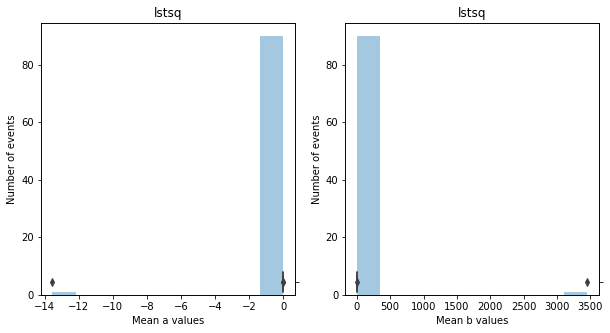

In [101]:
bootstrap_results(self, method="lstsq", no_iterations=100)

In [ ]:
import numpy as np
import random
 
x = np.random.normal(loc= 300.0, size=1000)
print(np.mean(x))
 
sample_mean = []
for i in range(50):
  y = random.sample(x.tolist(), 4)
  avg = np.mean(y)
  sample_mean.append(avg)
print(y)
 

# Results

Having the a (clock drift rate) and b (incurred timing error at t=0) values it is possible to calculate if there is a time shift while the OBS is sinking. For calculating it is necessary to have the initial dates when the OBS started recording.

In [ ]:
import pandas as pd
import obspy
import numpy as np
skew_values_file = "skew_values.csv"
path2file_skew = os.path.join(module_path, skew_values_file)
skew_df = pd.read_csv(path2file_skew, delimiter=",", header=0)
display(skew_df)

In [ ]:
cd.solution

In [ ]:
sensor_codes = skew_df["Sensor code"]
starttimes = skew_df["Start time"]
endtimes = skew_df["End time"]
ref_time = cd.reference_time
skew_measurements = skew_df["skew seconds"]


initial_shift = []
final_shift = []
corrected_stations = []
included_skews = []
clock_drift_per_day = []
for station, starttime, endtime, skew in zip(sensor_codes, starttimes,
                                       endtimes, skew_measurements):
    if station in cd.station_names:
        a = float(cd.solution["a ("+ station + ")"])
        b = float(cd.solution["b ("+ station + ")"])
        dt_start = (obspy.UTCDateTime(starttime) - ref_time)/86400
        dt_ins_start = a*(dt_start) + b
        initial_shift.append(dt_ins_start)
        
        try:
            dt_end = (obspy.UTCDateTime(endtime) - ref_time)/86400
            dt_ins_end = a*(dt_end) + b
        except:
            dt_ins_end = "Recovery time not provided"
        final_shift.append(dt_ins_end)
        corrected_stations.append(station)
        included_skews.append(skew)
        clock_drift_per_day.append(a)

In [ ]:
final_results = pd.DataFrame(list(zip(corrected_stations, initial_shift, 
                                      final_shift, included_skews, clock_drift_per_day)),
                             columns = ["Sensor code", "Incurred timing error at t=0 [s]",
                                       "Timing error at the time of recovery [s]",
                                        "Skew [s]", 
                                        "Clock drift [s/day]"])
display(final_results)

In [ ]:
print(final_results.to_latex(index=False))

In [ ]:
cd.stations[0]

In [ ]:
print(cd.solution.to_latex(index=False))